In [21]:
## convert to function
from imutils import contours
from skimage import measure
import numpy as np
import imutils
import cv2
import pandas as pd
import glob


import swifter
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [22]:
def get_disk(image):
  try:  
    image = cv2.imread(image)
    
    width = 512
    dim = (width, width)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    crop = 100
    image = image[100:width-100, 100:width-100]
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.bilateralFilter(gray,9,75,75)
    median=cv2.medianBlur(blur, 5)

    # threshold the image to reveal light regions in the
    # blurred image
    thresh = cv2.threshold(median, 155, 255, cv2.THRESH_BINARY)[1]
    # perform a series of erosions and dilations to remove
    # any small blobs of noise from the thresholded image
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)

    # perform a connected component analysis on the thresholded
    # image, then initialize a mask to store only the "large"
    # components
    labels = measure.label(thresh, connectivity=2, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    # loop over the unique components
    for label in np.unique(labels):
      # if this is the background label, ignore it
      if label == 0:
        continue

      # otherwise, construct the label mask and count the
      # number of pixels 
      labelMask = np.zeros(thresh.shape, dtype="uint8")
      labelMask[labels == label] = 255
      numPixels = cv2.countNonZero(labelMask)

      # if the number of pixels in the component is sufficiently
      # large, then add it to our mask of "large blobs"
      if numPixels >500:
        mask = cv2.add(mask, labelMask)

    # find the contours in the mask, then sort them from left to
    # right
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
      cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts)[0]
    # print (cnts)
    # loop over the contours
    for (i, c) in enumerate(cnts):
        ellipse = cv2.fitEllipse(c)
        (x, y, w, h) = cv2.boundingRect(c)
        break
      # draw the bright spot on the image

#     padding = 100
    image = image[y:y+h, x:x+w]
    return True
  except:
    return False

In [23]:
df = pd.DataFrame(columns=["path", "raises_exception"])

In [24]:
path_list = glob.glob("dataset/ocular/0/*.*")+glob.glob("dataset/ocular/1/*.*")

In [25]:
df['path'] = path_list

In [26]:
df

,path,raises_exception
0,dataset/ocular/0/2342_left.jpg,NaN
1,dataset/ocular/0/3407_right.jpg,NaN
2,dataset/ocular/0/2343_left.jpg,NaN
3,dataset/ocular/0/3294_right.jpg,NaN
4,dataset/ocular/0/940_right.jpg,NaN
...,...,...
3419,dataset/ocular/1/1964_left.jpg,NaN
3420,dataset/ocular/1/1265_right.jpg,NaN
3421,dataset/ocular/1/1965_left.jpg,NaN
3422,dataset/ocular/1/1503_right.jpg,NaN


In [27]:
df['raises_exception'] = df.path.swifter.progress_bar(enable=True).apply(get_disk)

In [30]:
df.to_csv("exceptions.csv", index=False)

In [31]:
df

,path,raises_exception
0,dataset/ocular/0/2342_left.jpg,True
1,dataset/ocular/0/3407_right.jpg,True
2,dataset/ocular/0/2343_left.jpg,False
3,dataset/ocular/0/3294_right.jpg,True
4,dataset/ocular/0/940_right.jpg,False
...,...,...
3419,dataset/ocular/1/1964_left.jpg,True
3420,dataset/ocular/1/1265_right.jpg,True
3421,dataset/ocular/1/1965_left.jpg,False
3422,dataset/ocular/1/1503_right.jpg,True


In [32]:
df_bad = df[~df.raises_exception]

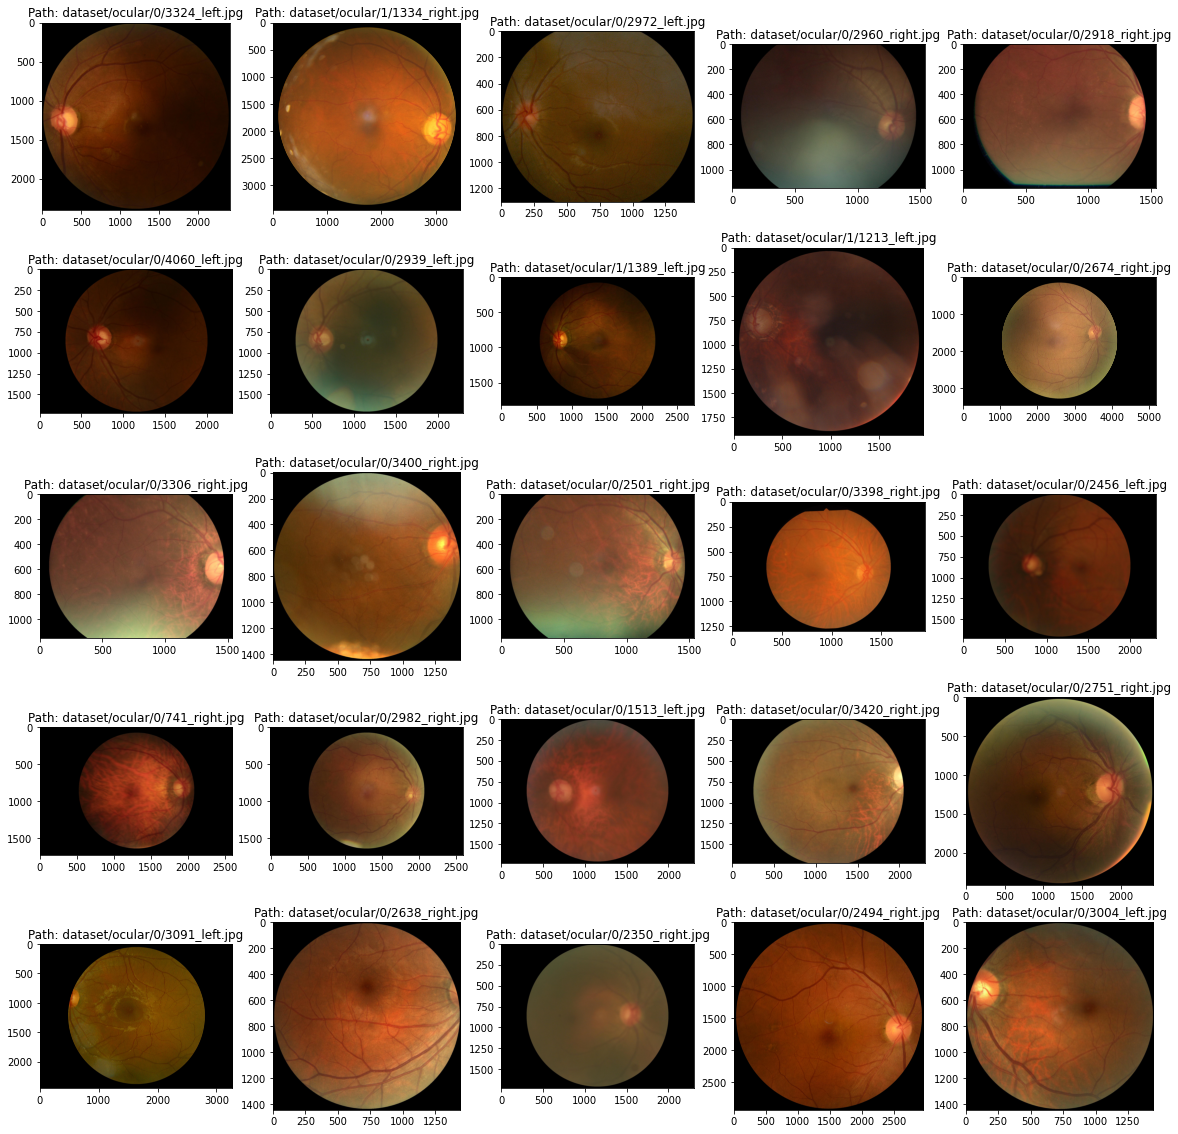

In [33]:
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    rand_img = df_bad.sample()
    path = rand_img.path.iloc[0]
    title = "Path: "+str(path)
    img = np.array(Image.open(rand_img.path.iloc[0]))
    fig.add_subplot(rows, columns, i, title=title)
    plt.imshow(img)
plt.show()